# Data Analysis

## Import

In [1]:
import pandas as pd # For handling and analyzing tabular data

# For visualization
import seaborn as sns
import matplotlib.pyplot as plt

import re # For validating and manipulating text
import numpy as np # For numeric calculation

## Read cleaned data from CSV file

In [2]:
anime_data = pd.read_csv('./data/anime_data_cleaned.csv')

# Check
anime_data

,Media Type,Premiered Season,Genres,User Score,Number of Members,Studios,Rating
0,tv,Spring 1979,"Adventure, Anthropomorphic, Comedy, Fantasy, K...",7.86,66328,Shin-Ei Animation,pg
1,tv,Spring 1989,"Action, Adventure, Comedy, Fantasy, Martial Ar...",8.19,1261770,Toei Animation,pg_13
2,tv,Spring 1992,"Comedy, Ecchi, School, Seinen",7.80,87291,Shin-Ei Animation,g
3,tv,Fall 1993,"School, Shounen, Sports, Team Sports",8.55,313954,Toei Animation,pg_13
4,tv,Winter 1994,"Adventure, Comedy, Fantasy, Mahou Shoujo, Roma...",7.40,16950,Gallop,g
...,...,...,...,...,...,...,...
2324,tv,Fall 2024,"Adult Cast, Drama, Seinen",7.03,18379,Madhouse,pg_13
2325,tv,Fall 2024,"Action, Adventure, Fantasy, Harem, Isekai",7.36,139526,asread.,r
2326,tv,Fall 2024,"Comedy, Romance",7.10,94185,Felix Film,pg_13
2327,tv,Fall 2024,"Action, Adventure, Fantasy, Isekai",6.57,86450,"Passione, Hayabusa Film",pg_13


## Question 01: What are user reviews on MAL for different anime genres like?
### Benefits of finding answer
- Understand audience **tastes** and **preferences** for watching anime.
- Gain an **overall** perspective on the **quality** of each anime genre.
### Find the answer by using data
- Calculate the **average** ```User Score``` for each **genre** (in ```included_genres```).
- Visualize to **compare** between **genres** and provide **comments**.

In [3]:
# Genres list
included_genres = [
    'action', 'adventure', 'comedy', 'drama', 'fantasy',
    'mystery', 'romance', 'sci-fi', 'sports',
    'slice of life', 'horror', 'supernatural'
]

In [4]:
# Calculate average User Score for each genre
genre_scores = (
    anime_data[['Genres', 'User Score']]
    .assign(Genres=anime_data['Genres'].str.split(', ')) # Split Genres into lists
    .explode('Genres') # Expand each genre into its own row
    .query('Genres.str.lower() in @included_genres', engine='python') # Filter for included genres
    .groupby('Genres', as_index=False) # Group by genres
    .agg({'User Score': 'mean'}) # Calculate the mean User Score
    .sort_values(by='User Score', ascending=False) # Sort by User Score decreasingly
    .rename(columns={'Genres': 'Genre', 'User Score': 'Average User Score'})  # Rename columns
    .round({'Average User Score': 2})  # Round Average User Score to 2 decimal places
    .reset_index(drop=True) # Fix indices
)

genre_scores

,Genre,Average User Score
0,Mystery,7.67
1,Slice of Life,7.66
2,Sports,7.66
3,Supernatural,7.63
4,Drama,7.61
5,Action,7.51
6,Romance,7.45
7,Adventure,7.45
8,Fantasy,7.45
9,Comedy,7.44


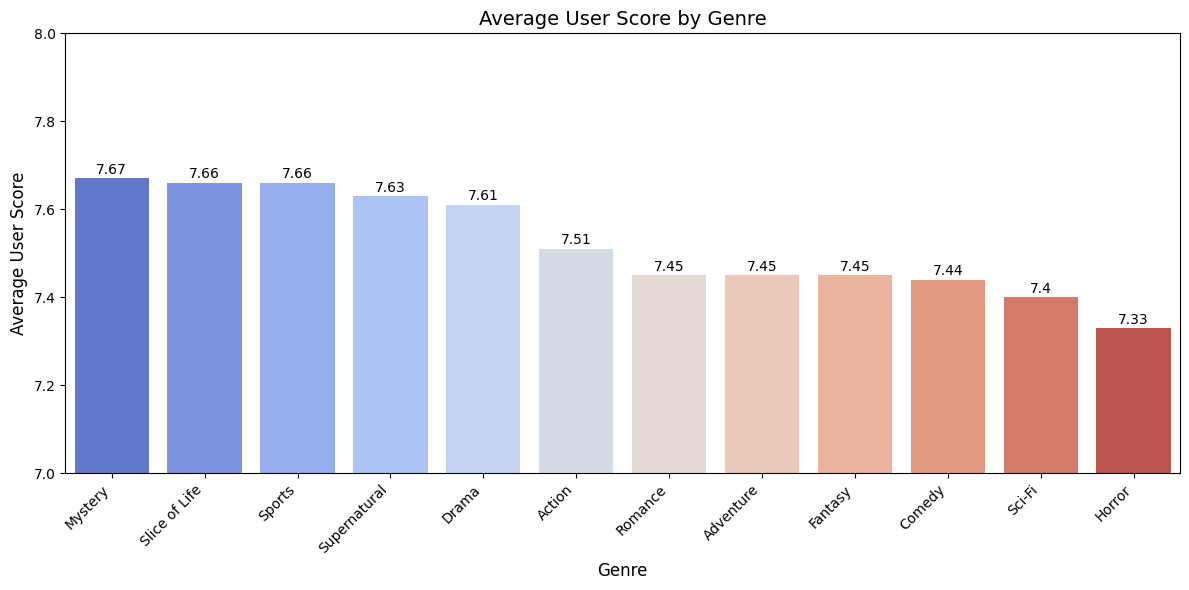

In [5]:
# Visualize the result by using vertical bar chart
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(
    x='Genre',
    y='Average User Score',
    data=genre_scores,
    palette='coolwarm',
    hue='Genre',
    legend=False
)

# Adjust Y-axis range to emphasize differences
plt.ylim(7, 8)  # Focus on the range of values

# Add specific values on top of each bar
for index, row in genre_scores.iterrows():
    bar_plot.text(
        x=index,
        y=row['Average User Score'] + 0.01,  # Position above the bar
        s=f"{row['Average User Score']}",
        ha='center',
        fontsize=10,
        color='black'
    )

plt.title("Average User Score by Genre", fontsize=14)
plt.xlabel("Genre", fontsize=12)
plt.ylabel("Average User Score", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)

plt.tight_layout()
plt.show()

### Comments
- The audience's ratings for each anime genre are **quite good** ($\geq 7$).
- The **highest-rated** anime genre by audience is **Mystery** ($\approx 7.67$).
- The **lowest-rated** anime genre by audience is **Horror** ($\approx 7.33$).

$\rightarrow$ **Divide** the anime genres into $2$ groups, each containing $6$ genres:
- **Higher-rated** anime genres: Mystery, Slice of Life, Sports, Supernatural, Drama, Action.
- **Lower-rated** anime genres: Romance, Adventure, Fantasy, Comedy, Sci-Fi, Horror.

In [6]:
# Define 2 genre groups
higher_rated_genres = ['mystery', 'slice of life', 'sports', 'supernatural', 'drama', 'action']
lower_rated_genres = ['romance', 'adventure', 'fantasy', 'comedy', 'sci-fi', 'horror']

## Question 02: How have user ratings for different anime genres changed over time?
### Benefits of finding answer
- Understand the **changes** in audience **tastes** and **preferences** for watching anime over the years.
- **Assess** the development in the **quality** of each anime genre over the years.
### Find the answer by using data
- **Divide** anime genres into $2$ groups, each containing $6$ genres: the **highest**-rated anime genres and the **lowest**-rated anime genres (based on the results of the previous question).
- Visualize the **changes** in the quality (average ```User Score```) of anime genres over time within each group, **compare** them, and provide **comments**.

In [7]:
# Convert Premiered Season to a datetime format
def season_to_datetime(season):
    season_map = {'Winter': 1, 'Spring': 4, 'Summer': 7, 'Fall': 10}
    season_name, year = season.split()
    return pd.Timestamp(year=int(year), month=season_map[season_name], day=1)

In [8]:
# Calculate average User Score for each genre group over the seasons
season_genre_scores = (
    anime_data[['Genres', 'User Score', 'Premiered Season']]
    .assign(
        Genres=anime_data['Genres'].str.split(', '), # Split Genres into lists
        Date=anime_data['Premiered Season'].apply(season_to_datetime) # Convert to datetime
    )
    .explode('Genres') # Expand genres into individual rows
    .assign(
        Genre_Group=lambda df: df['Genres'].str.lower().apply(
            lambda x: 'Higher-rated' if x in higher_rated_genres else 'Lower-rated' if x in lower_rated_genres else None
        )
    )
    .query('Genre_Group.notnull()', engine='python') # Filter for defined genre groups
    .groupby(['Date', 'Genre_Group'], as_index=False) # Group by Date and Genre_Group
    .agg({'User Score': lambda x: round(x.mean(), 2)}) # Calculate and round the mean User Score
    .rename(columns={'User Score': 'Average User Score', 'Genre_Group': 'Genre Group'}) # Rename column
    .sort_values('Date') # Ensure chronological order
)

season_genre_scores

,Date,Genre Group,Average User Score
0,1979-04-01,Lower-rated,7.86
1,1989-04-01,Higher-rated,8.19
2,1989-04-01,Lower-rated,8.19
3,1992-04-01,Lower-rated,7.80
4,1993-10-01,Higher-rated,8.55
...,...,...,...
245,2024-04-01,Lower-rated,7.78
246,2024-07-01,Higher-rated,7.40
247,2024-07-01,Lower-rated,7.46
248,2024-10-01,Higher-rated,7.75


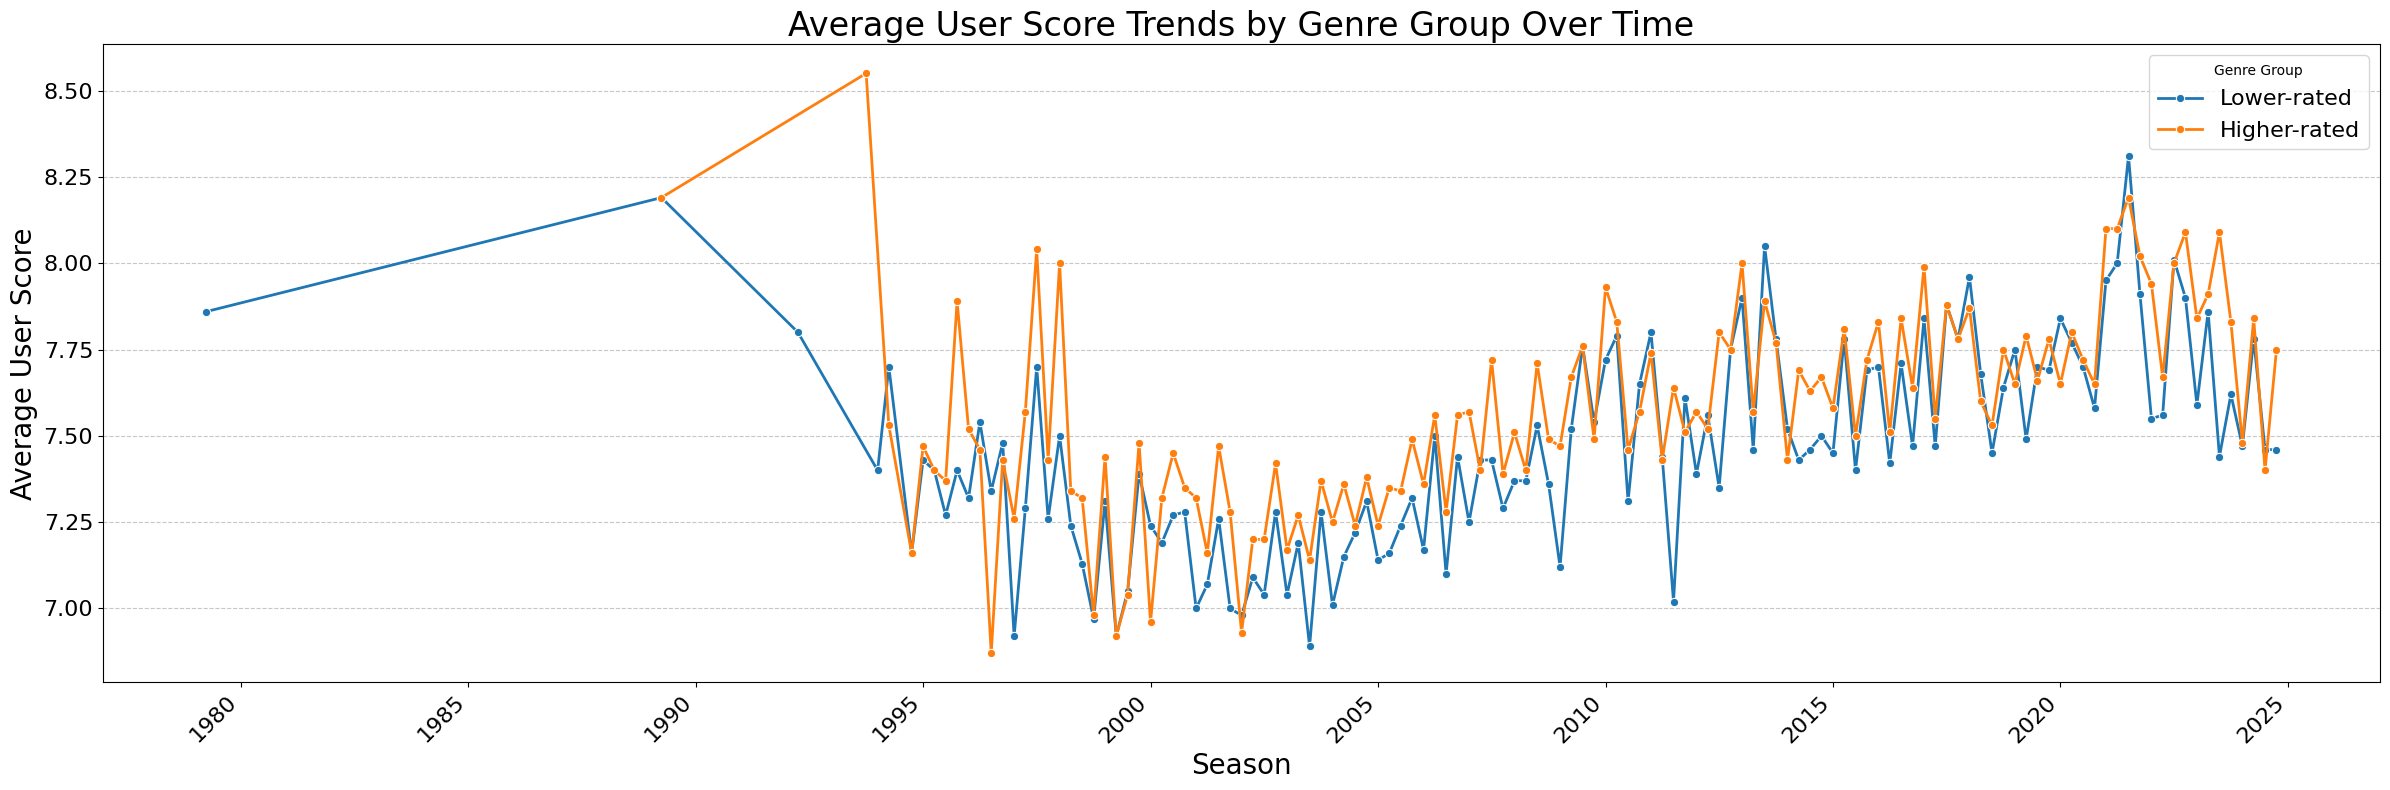

In [9]:
# Visualize the result by using line chart
plt.figure(figsize=(24, 8))
sns.lineplot(
    data=season_genre_scores,
    x='Date',
    y='Average User Score',
    hue='Genre Group',
    marker='o',
    linewidth=2
)

plt.title("Average User Score Trends by Genre Group Over Time", fontsize=24)
plt.xlabel("Season", fontsize=20)
plt.ylabel("Average User Score", fontsize=20)
plt.xticks(rotation=45, ha='right', fontsize=16)
plt.yticks(fontsize=16)
plt.legend(title='Genre Group', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### Comments

- Most of the time, **higher-rated** genres consistently receive **better** audience ratings (obviously).
- However, there are a **very small number** of **short periods** where lower-rated genres are rated **higher**, mostly concentrated in the **2010–2015** period.

$\rightarrow$ The **changes** in audience ratings over time are **incredibly complex** and **difficult to predict**, reflecting the **diverse development** of the anime market and the **shifting preferences** of viewers across different periods.

## Question 03: How has the number of anime in each genre changed over the years?
### Benefits of finding answer
- **Understand** and **analyze** the **development** of anime over the years.
- Combine with the results of the previous two questions to **identify and evaluate** the **relationship** between ```User Score```, **genres**, and the **number of anime**.
### Find the answer by using data
- Visualize the **changes** in the **number of anime** in each genre over time within each group, **compare** them, and provide **comments**.
- **Combine** with the **results** of the previous two questions to draw **final conclusions** about the **relationship** between ```User Score```, **genres**, and the **number of anime**.

In [10]:
# Calculate the number of anime for each genre group over the seasons
genre_anime_counts = (
    anime_data[['Genres', 'Premiered Season']]
    .assign(
        Genres=anime_data['Genres'].str.split(', '), # Split Genres into lists
        Date=anime_data['Premiered Season'].apply(season_to_datetime) # Convert to datetime
    )
    .explode('Genres') # Expand genres into individual rows
    .assign(
        Genre_Group=lambda df: df['Genres'].str.lower().apply(
            lambda x: 'Higher-rated' if x in higher_rated_genres else 'Lower-rated' if x in lower_rated_genres else None
        )
    )
    .query('Genre_Group.notnull()', engine='python') # Filter for defined genre groups
    .groupby(['Date', 'Genre_Group'], as_index=False) # Group by Date and Genre_Group
    .agg({'Genres': 'count'}) # Count the number of anime
    .rename(columns={'Genres': 'Count', 'Genre_Group': 'Genre Group'}) # Rename column
    .sort_values('Date') # Ensure chronological order
)

genre_anime_counts

,Date,Genre Group,Count
0,1979-04-01,Lower-rated,4
1,1989-04-01,Higher-rated,1
2,1989-04-01,Lower-rated,3
3,1992-04-01,Lower-rated,1
4,1993-10-01,Higher-rated,1
...,...,...,...
245,2024-04-01,Lower-rated,25
246,2024-07-01,Higher-rated,17
247,2024-07-01,Lower-rated,34
248,2024-10-01,Higher-rated,31


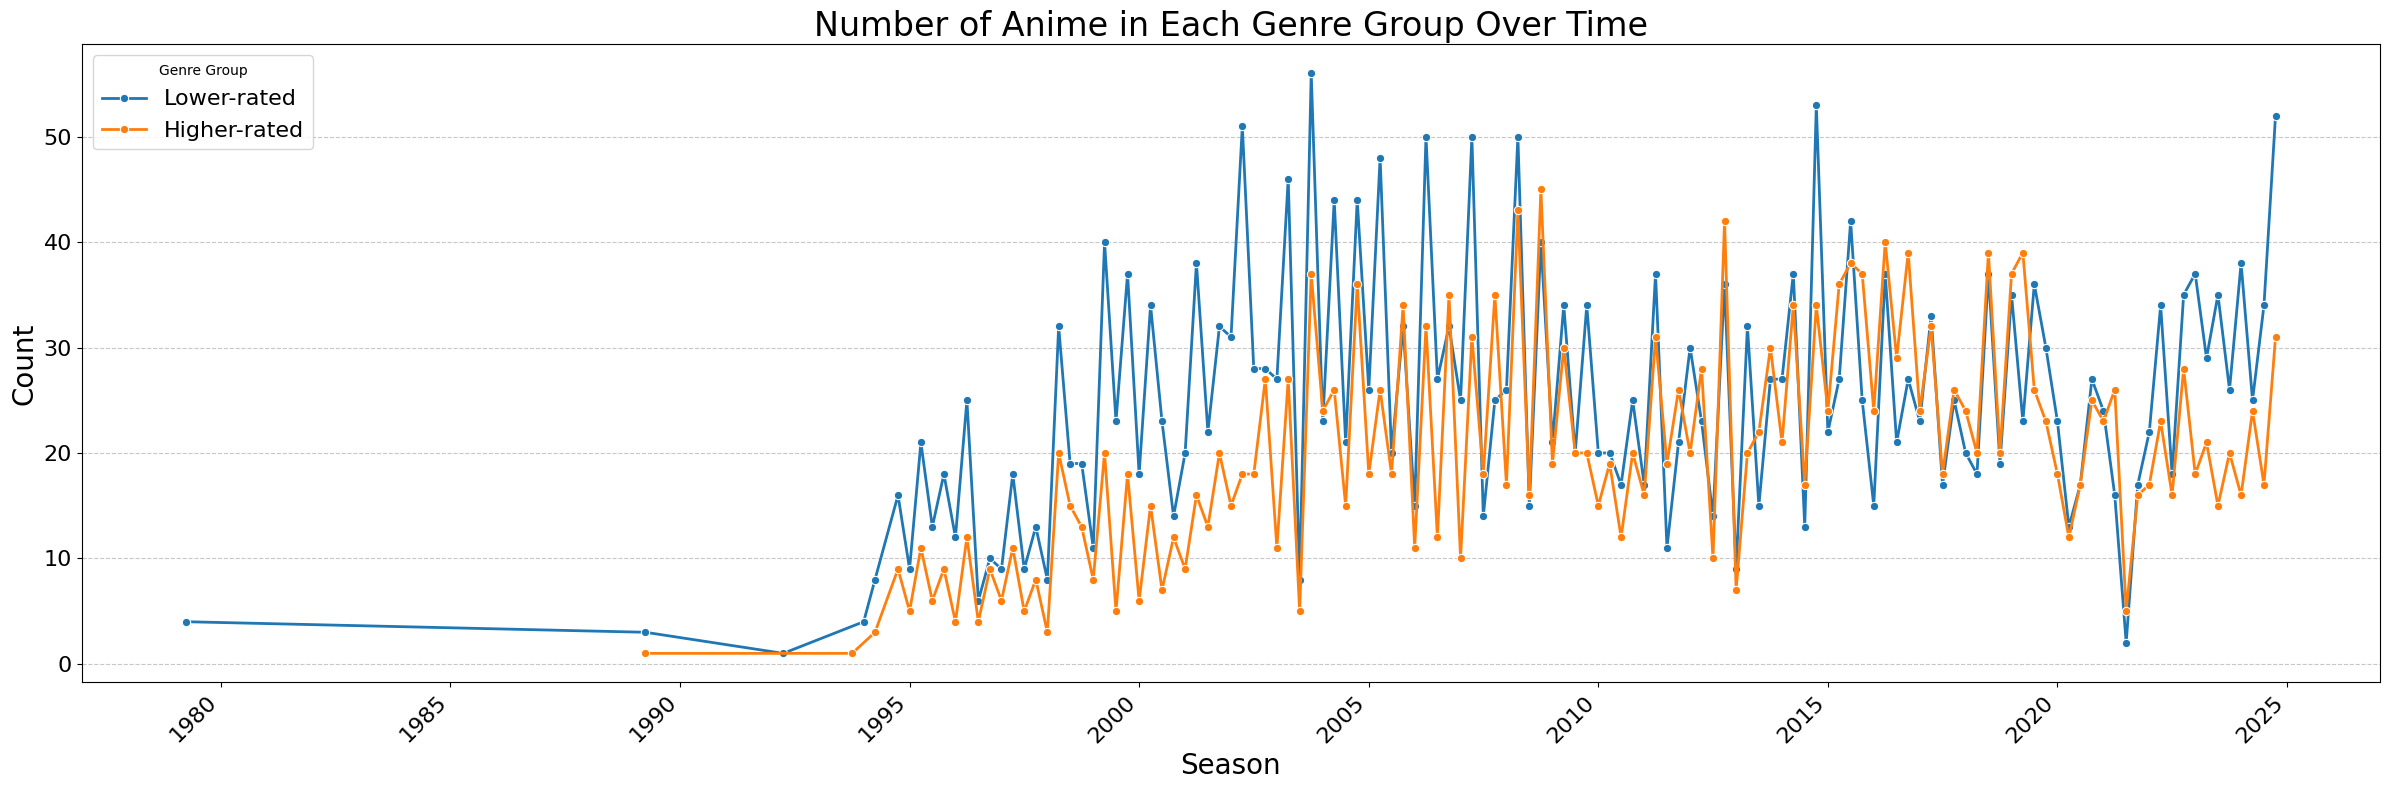

In [11]:
# Visualize the result by using line chart
plt.figure(figsize=(24, 8))
sns.lineplot(
    data=genre_anime_counts,
    x='Date',
    y='Count',
    hue='Genre Group',
    marker='o',
    linewidth=2
)
plt.title("Number of Anime in Each Genre Group Over Time", fontsize=24)
plt.xlabel("Season", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.xticks(rotation=45, ha='right', fontsize=16)
plt.yticks(fontsize=16)
plt.legend(title='Genre Group', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### Comments
- For the majority of the time, the number of anime in the **lower-rated** genre group is always **greater than** that of the higher-rated genre group, and **significantly greater** in many cases.
- During certain periods, the number of anime in the **higher-rated** genre group **slightly surpasses** that of the lower-rated genre group.
$\rightarrow$ The **change** in the **number of anime** over time is also **very complex**, with even **significant fluctuations** between **consecutive seasons**.

### Conclusions
- There is a **relationship** between **audience ratings** and the **number of anime**: In most cases, anime with **lower ratings** tend to have a **larger quantity** compared to those with higher ratings.
- Comparing the **changes** in audience ratings with the number of anime **over time**, no **clear correlation** is observed $\rightarrow$ The relationship is **not very strong** (non-linear).
- Grouping anime by genre **helps** identify and evaluate the relationship between the feature ```User Score``` and the **number of anime** (the *target* in **data modeling**).

$\rightarrow$ ```User Score``` is an **essential feature** in the **regression** model; however, we still need to perform **additional analyses** on other features in dataset to **identify** additional necessary features, ensuring the **model's accuracy**.

## Question 04: How popular are the Genres? What are the Top 6 Genres with the highest popularity and Top 6 Genres with the least popularity over the past years?

### Brief explanation
- Analyze the **average number of members** for each genre in the included genres list to understand their relative popularity.

### Benefits of finding answer
- **Identify** which genres attract the most members on average.
- Help creators and marketers **focus** on genres with high member engagement.

### Find the answer by using data
- Use the `Genres` and `Number of Members` columns.
- Filter the data for included genres only.
- Split the `Genres` column into separate rows for each genre.
- Group the data by the `Genres` column and calculate the average `Number of Members` for each genre.
- Sort the results to identify the genres with the highest average member count.
- Visualize the results using a vertical bar chart.

In [12]:
# Calculate the average number of members for each genre
genre_population = (
    anime_data[['Genres', 'Number of Members']]
    .assign(Genres=anime_data['Genres'].str.split(', ')) # Split Genres into lists
    .explode('Genres') # Expand each genre into its own row
    .query('Genres.str.lower() in @included_genres', engine='python') # Filter for included genres
    .assign(Genres=lambda df: df['Genres'].str.lower()) # Normalize genre names to lowercase
    .groupby('Genres', as_index=False) # Group by genres
    .agg({'Number of Members': 'mean'}) # Calculate the mean number of members
    .rename(columns={'Genres': 'Genre', 'Number of Members': 'Average Number of Members'}) # Rename columns
    .sort_values(by='Average Number of Members', ascending=False) # Sort by average number of members descending
    .round({'Average Number of Members': 0}) # Round Average Number of Members to 0 decimal places
    .reset_index(drop=True) # Fix indices
)   

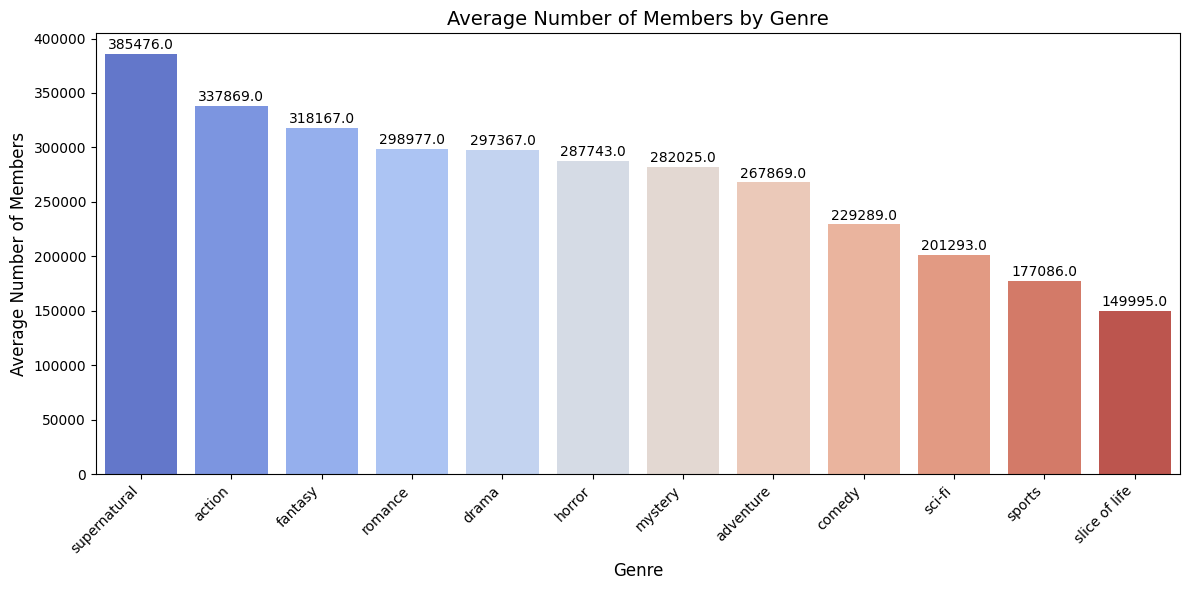

In [13]:
# Visualize the result by using a vertical bar chart
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(
    x='Genre',
    y='Average Number of Members',
    data=genre_population,
    palette='coolwarm',
    hue='Genre',
    dodge=False,
    legend=False
)

# Add specific values on top of each bar
for index, row in genre_population.iterrows():
    bar_plot.text(
        x=index,
        y=row['Average Number of Members'] + 4500,  # Position above the bar
        s=f"{row['Average Number of Members']}",
        ha='center',
        fontsize=10,
        color='black'
    )

plt.title("Average Number of Members by Genre", fontsize=14)
plt.xlabel("Genre", fontsize=12)
plt.ylabel("Average Number of Members", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

### Comments
- 6 genres that viewers are most interested in are: ```supernatural```, ```action```, ```fantasy```, ```romance```, ```drama``` and ```horror```.
- 6 genres that viewers are least interested in are: ```slice of life```, ```sports```, ```sci-fi```, ```comedy```, ```adventure``` and ```mystery```.

## Question 05: How has the average number of members for higher-populated and lower-populated genres changed over time ?

### Brief explanation
- Analyze how the **average number of members** for higher-populated and lower-populated genres has changed over time.

### Benefits of finding answer
- **Track trends** in audience engagement for different genres over time.
- Help creators and marketers identify which genres are gaining or losing popularity.

### Find the answer by using data
- Use the `Genres`, `Number of Members`, and `Premiered Season` columns.
- Filter the data for included genres only.
- Split the `Genres` column into separate rows for each genre.
- Assign each genre to a group: higher-populated or lower-populated.
- Group the data by season and genre group.
- Calculate the average number of members for each group in each season.
- Visualize the results using a line chart.

In [14]:
# Define higher-populated and lower-populated genres
higher_populated_genres = genre_population.head(6)['Genre'].tolist()
lower_populated_genres = genre_population.tail(6)['Genre'].tolist()

In [15]:
# Calculate the average number of members for each genre group over the seasons
season_genre_population = (
    anime_data[['Genres', 'Number of Members', 'Premiered Season']]
    .assign(
        Genres=anime_data['Genres'].str.split(', '), # Split Genres into lists
        Date=anime_data['Premiered Season'].apply(season_to_datetime)  # Convert to datetime
    )
    .explode('Genres') # Expand genres into individual rows
    .assign(
        Genre_Group=lambda df: df['Genres'].str.lower().apply(
            lambda x: 'Higher-populated' if x in higher_populated_genres else 'Lower-populated' if x in lower_populated_genres else None
        )
    )
    .query('Genre_Group.notnull()', engine='python') # Filter for defined genre groups
    .groupby(['Date', 'Genre_Group'], as_index=False) # Group by Date and Genre_Group
    .agg({'Number of Members': lambda x: round(x.mean(), 2)}) # Calculate and round the mean number of members
    .rename(columns={'Number of Members': 'Average Number of Members', 'Genre_Group': 'Genre Group'}) # Rename column
    .sort_values('Date') # Ensure chronological order
)
season_genre_population

,Date,Genre Group,Average Number of Members
0,1979-04-01,Higher-populated,66328.00
1,1979-04-01,Lower-populated,66328.00
2,1989-04-01,Higher-populated,1261770.00
3,1989-04-01,Lower-populated,1261770.00
4,1992-04-01,Lower-populated,87291.00
...,...,...,...
247,2024-04-01,Lower-populated,165147.72
248,2024-07-01,Higher-populated,122120.03
249,2024-07-01,Lower-populated,140274.11
250,2024-10-01,Higher-populated,109079.40


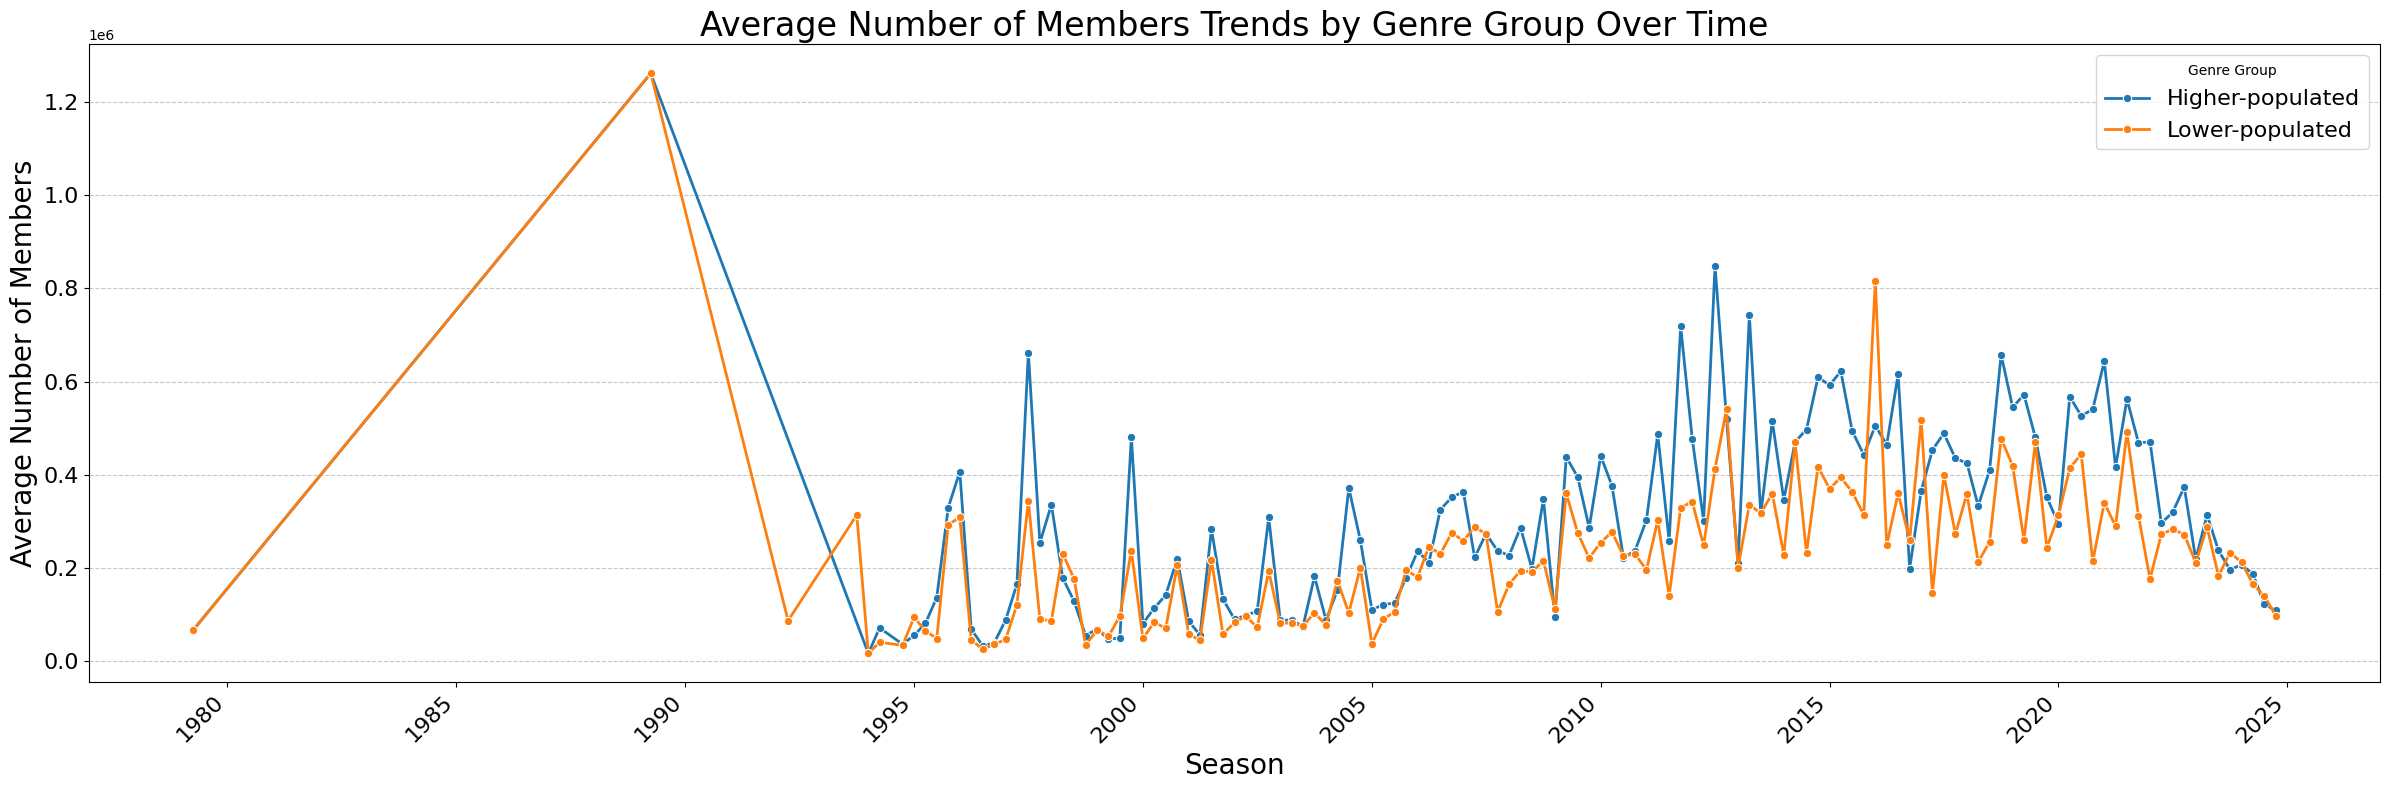

In [16]:
# Visualize the result by using line chart
plt.figure(figsize=(24, 8))
sns.lineplot(
    data=season_genre_population,
    x='Date',
    y='Average Number of Members',
    hue='Genre Group',
    marker='o',
    linewidth=2
)

plt.title("Average Number of Members Trends by Genre Group Over Time", fontsize=24)
plt.xlabel("Season", fontsize=20)
plt.ylabel("Average Number of Members", fontsize=20)
plt.xticks(rotation=45, ha='right', fontsize=16)
plt.yticks(fontsize=16)
plt.legend(title='Genre Group', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### Comments
- Over time, higher-populated genres tend to dominate the number of anime produced compared to lower-populated genres.
- There are some periods of convergence where both genre groups produce a similar number of anime, often during transitional phases in the anime industry (e.g., mid-2000s).
- The trends reflect a strong focus on popular genres, likely driven by their market appeal and ability to attract a larger audience.

$\rightarrow$ The data suggests that production volume for genres aligns with their audience size, emphasizing the importance of genre popularity in determining the number of anime created.

## Question 06: How has the number of anime of the 6 highest/lowest genres changed over the years?

### Brief explanation
- Analyze how the **number of anime** in higher-populated and lower-populated genres has changed over time.

### Benefits of finding answer
- **Track trends** in production volume for different genres over time.
- Help creators and marketers understand which genres are being focused on by the industry.

### Find the answer by using data
- Use the `Genres` and `Premiered Season` columns.
- Filter the data for included genres only.
- Split the `Genres` column into separate rows for each genre.
- Assign each genre to a group: higher-populated or lower-populated, based on the top 6 and bottom 6 genres by average number of members.
- Group the data by season and genre group.
- Count the number of anime in each group for each season.
- Visualize the results using a line chart.

In [17]:
# Calculate the number of anime for each genre group over the seasons
genre_anime_counts_v2 = (
    anime_data[['Genres', 'Premiered Season']]
    .assign(
        Genres=anime_data['Genres'].str.split(', '), # Split Genres into lists
        Date=anime_data['Premiered Season'].apply(season_to_datetime) # Convert to datetime
    )
    .explode('Genres') # Expand genres into individual rows
    .assign(
        Genre_Group=lambda df: df['Genres'].str.lower().apply(
            lambda x: 'Higher-populated' if x in higher_populated_genres else 'Lower-populated' if x in lower_populated_genres else None
        )
    )
    .query('Genre_Group.notnull()', engine='python') # Filter for defined genre groups
    .groupby(['Date', 'Genre_Group'], as_index=False) # Group by Date and Genre_Group
    .agg({'Genres': 'count'}) # Count the number of anime
    .rename(columns={'Genres': 'Count', 'Genre_Group': 'Genre Group'}) # Rename column
    .sort_values('Date') # Ensure chronological order
)

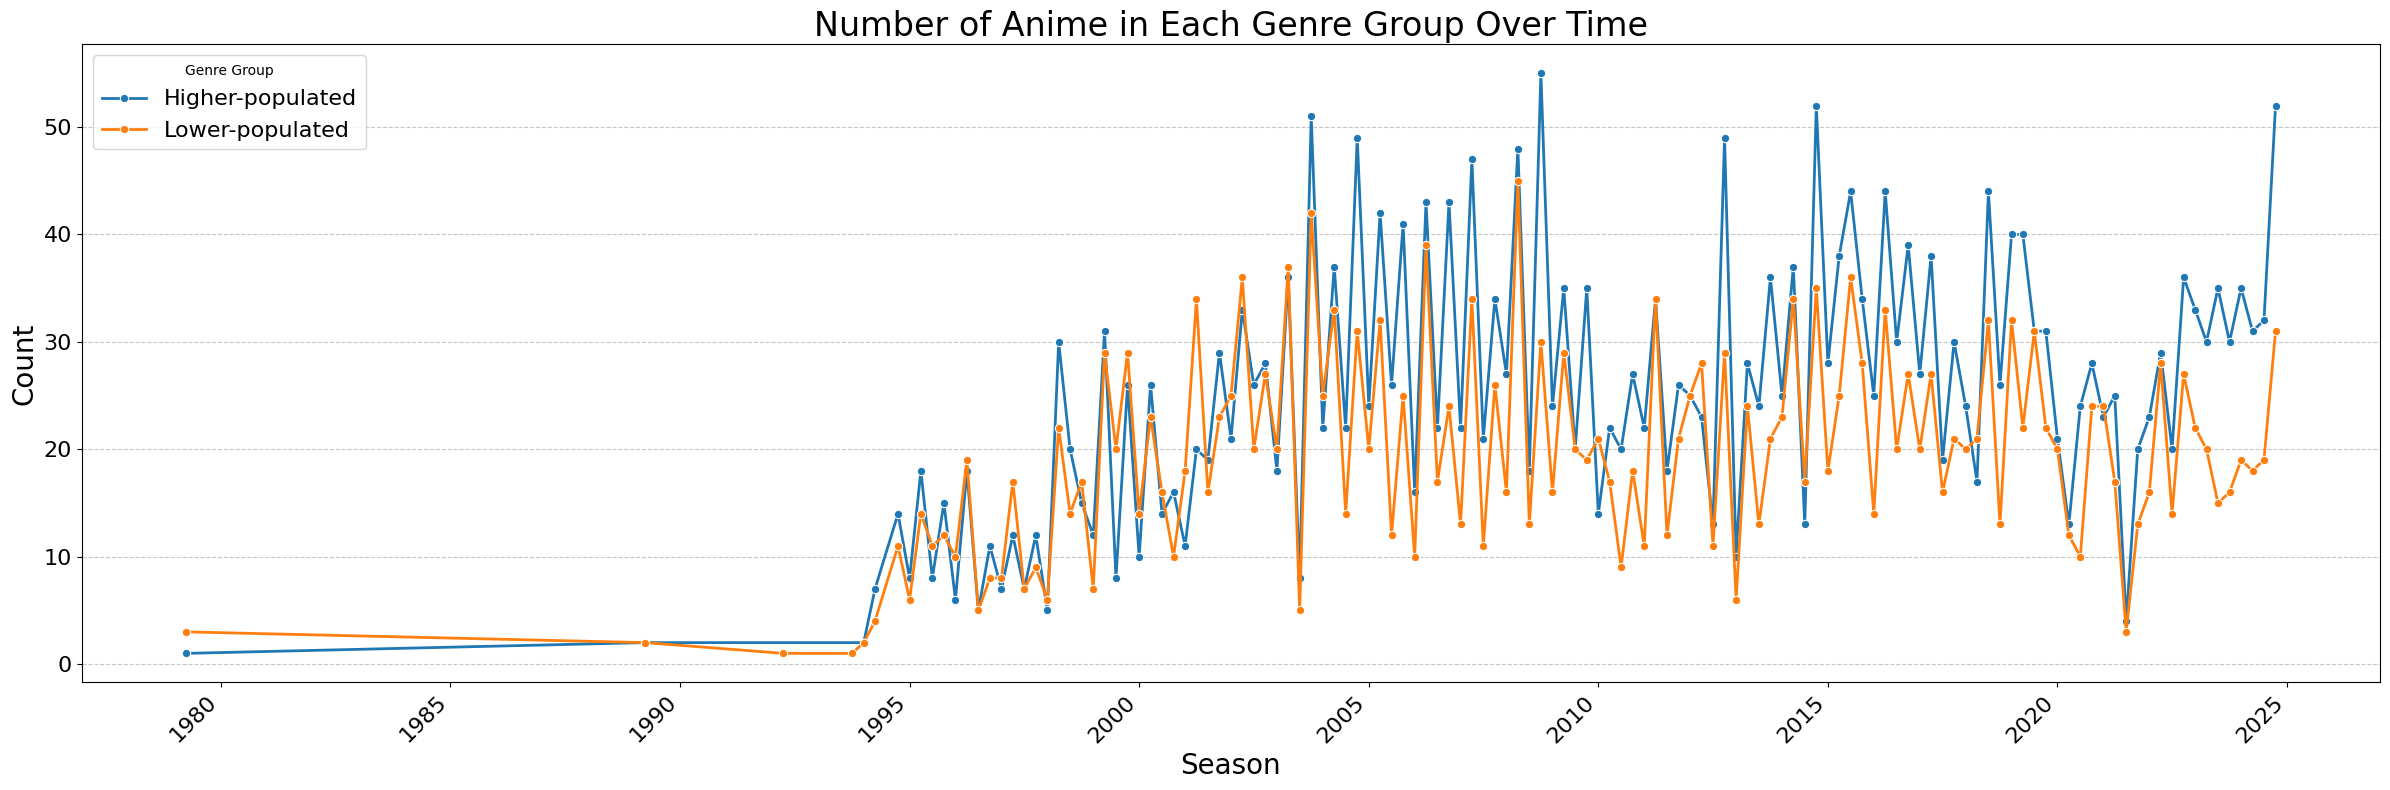

In [18]:
# Visualize the result by using line chart
plt.figure(figsize=(24, 8))
sns.lineplot(
    data=genre_anime_counts_v2,
    x='Date',
    y='Count',
    hue='Genre Group',
    marker='o',
    linewidth=2
)

plt.title("Number of Anime in Each Genre Group Over Time", fontsize=24)
plt.xlabel("Season", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.xticks(rotation=45, ha='right', fontsize=16)
plt.yticks(fontsize=16)
plt.legend(title='Genre Group', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### Comments:
- Over time, the higher-populated genre group generally has a lower count of anime compared to the lower-populated genre group. This suggests that genres with a high average number of members tend to have fewer individual anime series, possibly due to their focus on high-impact productions or franchise consistency.
- Fluctuations in the number of anime in both groups are apparent, with both groups experiencing significant increases from the early 2000s, likely driven by the growing anime industry and global popularity.
- From 2015 onward, both groups appear to converge in the number of anime, indicating an increased focus across diverse genres to cater to a broader audience base.

$\rightarrow$ This trend highlights the anime industry's dynamic growth and strategic shifts over time, balancing audience preferences with production capabilities.

## Question 7: How has the average User Score of TV and Movie media types changed over time?

The Average User Score trends highlight differences in audience reception and release patterns between TV and Movie media types. While TV provides consistent quality, Movies exhibit wider variability, potentially reflecting the impact of individual standout titles or shifts in content focus.

### Brief explanation
- Analyze how the **average User Score** of TV and Movie media types has changed over time.

### Benefits of finding the answer
- **Understand audience preferences**: Identify how the reception of TV and Movie media types has evolved over time.
- **Inform future productions**: Help creators and producers understand the historical performance of different media types to guide future content strategies.

### Find the answer by using data
- Use the `Media Type` and `Premiered Season` columns.
- Filter the data for `TV` and `Movie` media types only.
- Extract the release year from the `Premiered Season` column to organize data chronologically.
- Group the data by `Release Year` and `Media Type`.
- Calculate the average `User Score` for each combination of `Release Year` and `Media Type`.
- Visualize the results using a line chart to show trends over time.


- Load the anime data (replace with your file path if needed)

In [19]:
tv_movie_data = anime_data[anime_data['Media Type'].isin(['tv', 'movie'])]

- Extract release year from "Premiered Season" column (assuming format "Season Year")

In [20]:
def extract_year(season):
    if isinstance(season, str):
        return int(season.split()[-1])
    return None

- Prepare the columns needed for drawing the chart

In [21]:
tv_movie_data['Release Year'] = tv_movie_data['Premiered Season'].apply(extract_year)

# Drop rows with missing year
tv_movie_data = tv_movie_data.dropna(subset=['Release Year'])

# Calculate the average User Score for each year and media type
avg_user_score = (
    tv_movie_data.groupby(['Release Year', 'Media Type'], as_index=False)
    .agg({'User Score': 'mean'})
    .rename(columns={'User Score': 'Average User Score'})
)

- Draw a chart and comment

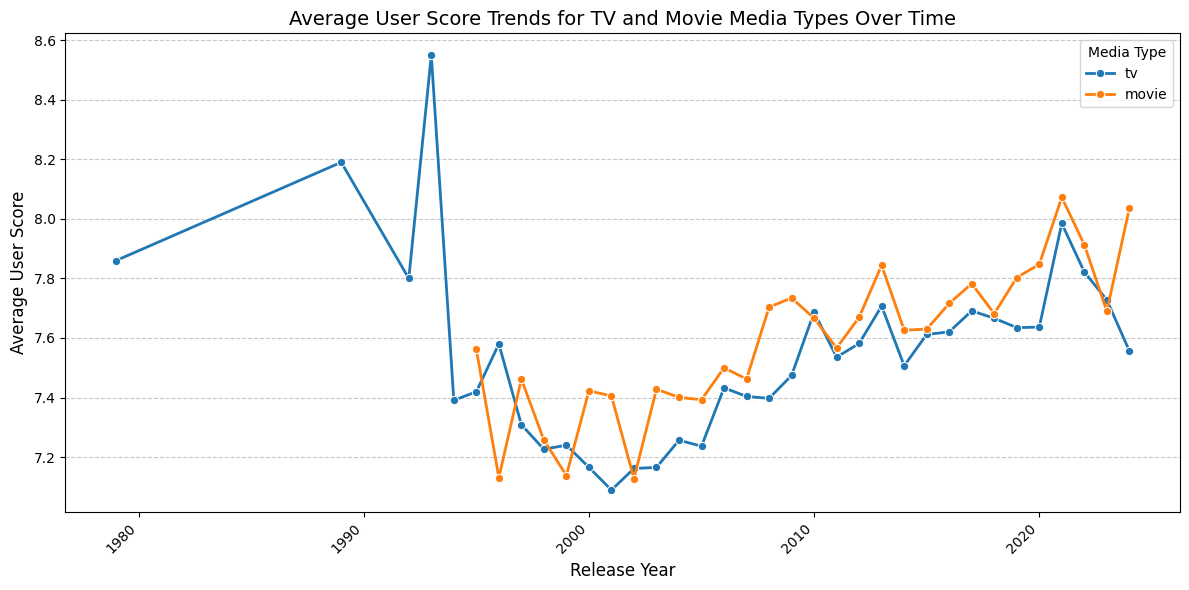

In [22]:
# Plot the trend of Average User Score over time
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=avg_user_score,
    x='Release Year',
    y='Average User Score',
    hue='Media Type',
    marker='o',
    linewidth=2
)

plt.title("Average User Score Trends for TV and Movie Media Types Over Time", fontsize=14)
plt.xlabel("Release Year", fontsize=12)
plt.ylabel("Average User Score", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Media Type", fontsize=10)
plt.tight_layout()
plt.show()


### Comments: 
- Over time, TV media types demonstrate more consistent trends in Average User Score, with scores generally stabilizing after an initial period of fluctuation.
- Movie media types show greater variability, with notable peaks in specific years, likely driven by the release of high-quality or widely acclaimed films.
- There is a convergence between TV and Movie scores in recent years, indicating a narrowing gap in audience reception.

$\rightarrow$ The data suggests that while TV media types maintain steady audience approval, Movies experience spikes in reception driven by standout titles. This highlights the importance of individual hits in shaping the perception of Movies.

## Question 8: How has the average Number of Members of TV and Movie media types changed over time?

The trends in the average number of members highlight the expanding reach of anime, with TV maintaining a consistent lead in engagement and Movies experiencing notable spikes during key releases. This indicates the growing influence of anime across both media types.

### Brief explanation
- Analyze how the **average Number of Members** of TV and Movie media types has changed over time.

### Benefits of finding the answer
- **Understand audience engagement**: Identify how the popularity of TV and Movie media types has evolved over time.
- **Inform marketing strategies**: Help industry stakeholders determine which media types are driving viewer interest and engagement.

### Find the answer by using data
- Use the `Media Type` and `Premiered Season` columns.
- Filter the data for `TV` and `Movie` media types only.
- Extract the release year from the `Premiered Season` column to organize data chronologically.
- Group the data by `Release Year` and `Media Type`.
- Calculate the average `Number of Members` for each combination of `Release Year` and `Media Type`.
- Visualize the results using a line chart to show trends over time.


- Prepare the columns needed for drawing the chart

In [23]:
# Calculate the average Number of Members for each year and media type
avg_number_of_members = (
    tv_movie_data.groupby(['Release Year', 'Media Type'], as_index=False)
    .agg({'Number of Members': 'mean'})
    .rename(columns={'Number of Members': 'Average Number of Members'})
)

- Draw a chart and comment

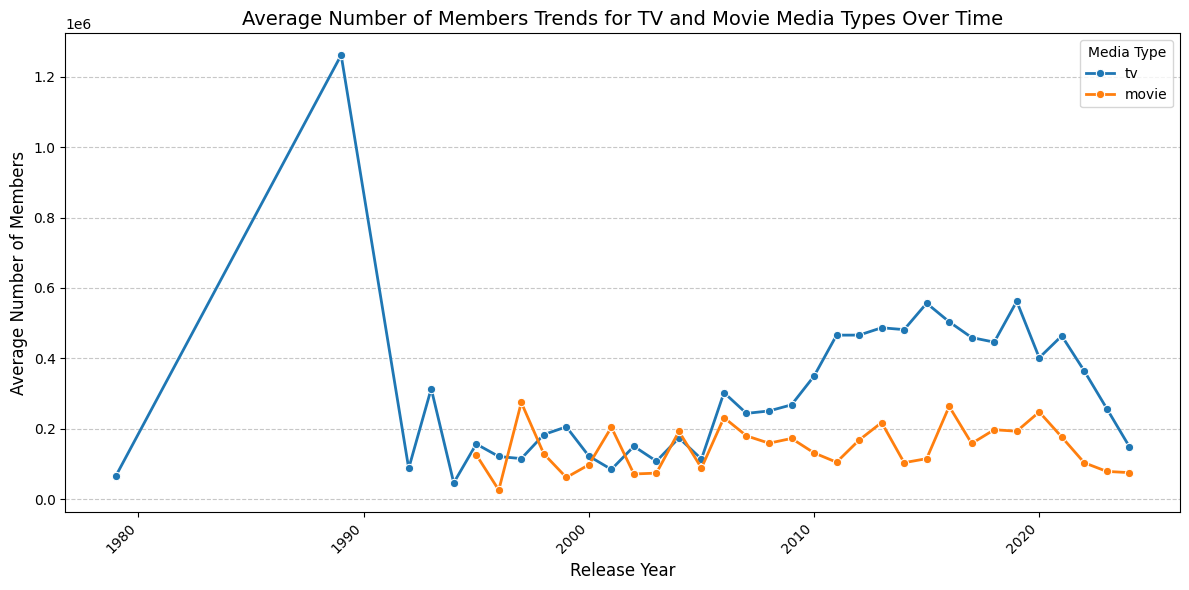

In [24]:
# Plot the trend of Average Number of Members over time
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=avg_number_of_members,
    x='Release Year',
    y='Average Number of Members',
    hue='Media Type',
    marker='o',
    linewidth=2
)

plt.title("Average Number of Members Trends for TV and Movie Media Types Over Time", fontsize=14)
plt.xlabel("Release Year", fontsize=12)
plt.ylabel("Average Number of Members", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Media Type", fontsize=10)
plt.tight_layout()
plt.show()

### Comments:
- Over time, TV media types consistently attract a larger average number of members compared to Movie media types, highlighting their widespread appeal and regular engagement with audiences.
- Movie media types show relatively stable trends, with fewer fluctuations compared to TV, possibly due to their limited frequency of release and targeted audiences.
- Both media types show a decline in the average number of members in recent years, potentially reflecting shifts in viewer preferences or competition from alternative content platforms.

$\rightarrow$ The data suggests that while TV media types maintain a higher engagement level overall, Movies tend to achieve stability in their audience size, focusing on quality over quantity.